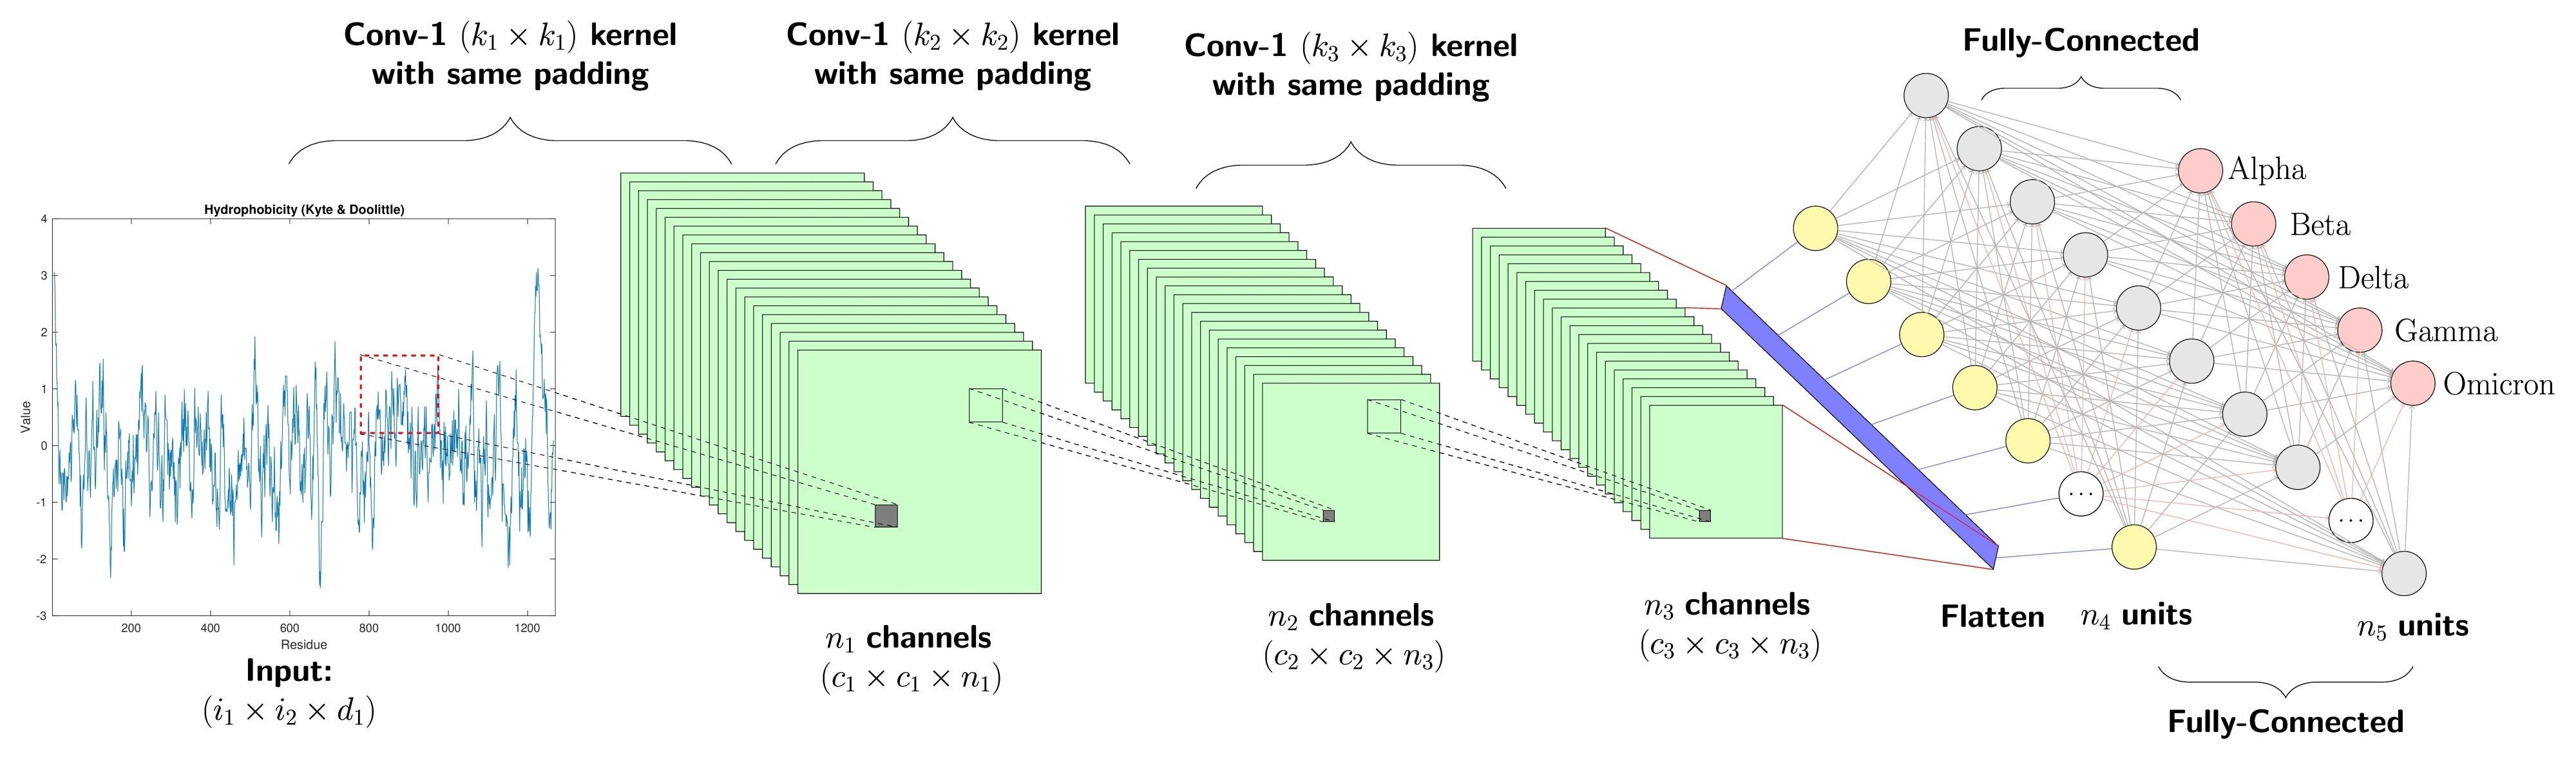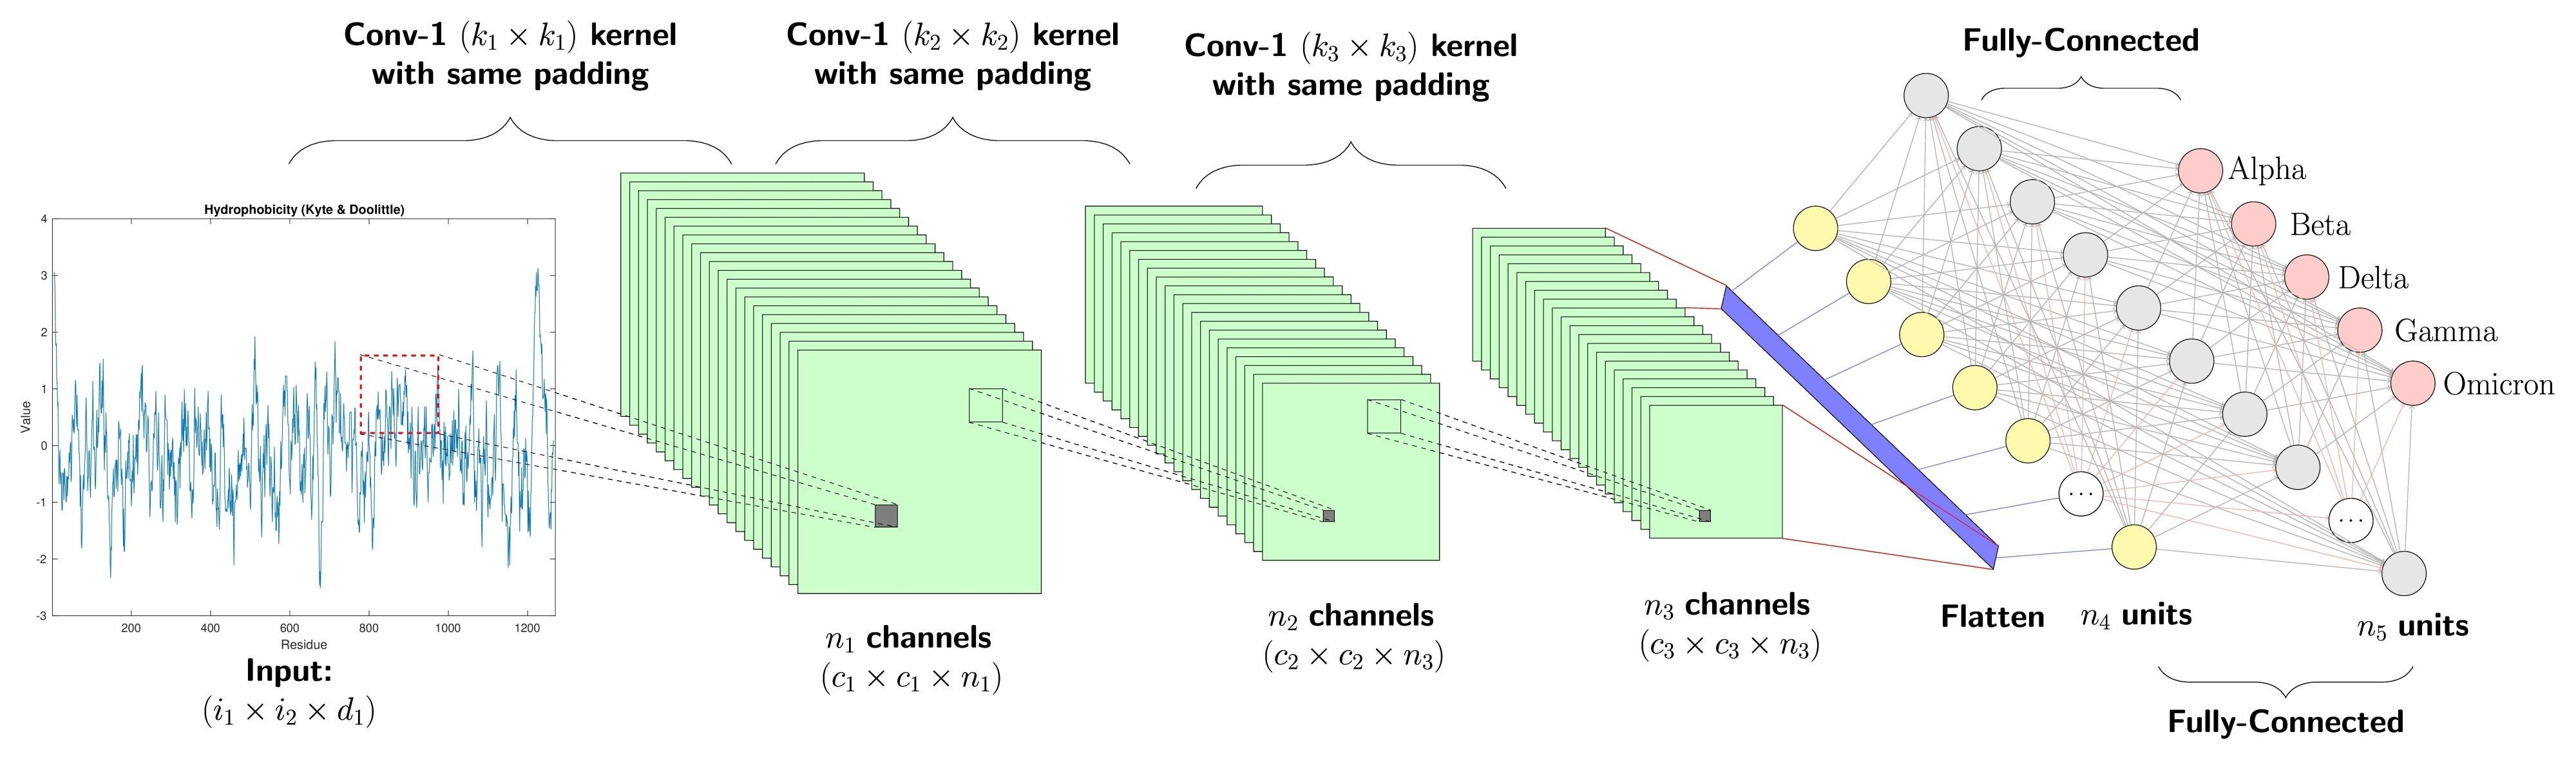

In [5]:
import torch
from  torch import nn
from torch.nn import functional as F
import math
import numpy as np

class SelfAttention(nn.Module):
    def __init__(self, n_heads:int, d_embd:int, in_proj_bias = True, out_proj_bias = True):
        super().__init__()
        self.in_proj = nn.Linear(d_embd, 3 * d_embd, bias = in_proj_bias)
        self.out_proj = nn.Linear(d_embd, d_embd, bias = out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embd // n_heads

    def forward(self, x: torch.Tensor, causal_mask = False):
        input_shape = x.shape # x = (batch_size, seq_len, dim)
        batch_size, sequence_length, d_embd = input_shape
        intermim_shape =  (batch_size, sequence_length, self.n_heads, self.d_head)
        q, k, v = self.in_proj(x).chunk(3, dim = -1) # (batch_size, seq_len, dim) -> (batch_size, seq_len, dim * 3) -> 3 tensors of shape (batch_size, seq_len, dim)
        q = q.view(intermim_shape).transpose(1, 2) # (batch_size, seq_len, h, dim/h) -> (batch_size, h, seq_len, dim/h)
        k = k.view(intermim_shape).transpose(1, 2)
        v = v.view(intermim_shape).transpose(1, 2)
        weight = q @ k.transpose(-1, -2) # (batch_size, h, seq_len, seq_len)
        if causal_mask:
            mask = torch.ones_like(weight, dtype = torch.bool).triu(1) # Mask where upper triangle is made of 1s
            weight.masked_fill_(mask, -torch.inf)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim = -1)
        output = weight @ v # (batch_size, h, seq_len, seq_len) @ (batch_size, h, seq_len, dim/h) -> (batch_size, h, seq_len, dim/h)
        output = output.transpose(1, 2)
        output = output.reshape(input_shape)
        output = self.out_proj(output)            
        return output # (batch_size, seq_len, Dim)

class CrossAttention(nn.Module):
    def __init__(self, n_head: int, d_embed: int, d_cross: int, in_proj_bias = True, out_proj_bias = True):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias = in_proj_bias)
        self.k_proj = nn.Linear(d_cross, d_embed, bias = in_proj_bias)
        self.v_proj = nn.Linear(d_cross, d_embed, bias = in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias = out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads  

    def forward(self, x, y): 
        # x: (latent) shape: (batch_size, seq_len_q, dim_q)
        # y: (context) shape: (batch_size, seq_len_kv, dim_kv)
        input_shape = x.shape
        batch_size, sequence_length_q, d_embed = input_shape
        sequence_length_kv = y.shape[1]
        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)
        # Reshape for multi-head attention
        q = q.view(batch_size, sequence_length_q, self.n_heads, self.d_head).transpose(1, 2)
        k = k.view(batch_size, sequence_length_kv, self.n_heads, self.d_head).transpose(1, 2)
        v = v.view(batch_size, sequence_length_kv, self.n_heads, self.d_head).transpose(1, 2)
        weight = q @ k.transpose(-1, -2)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)        
        output = weight @ v
        output = output.transpose(1, 2).contiguous()
        output = output.view(input_shape)
        output = self.out_proj(output)
        return output

class VAE_Encoder(nn.Sequential):
    def __init__(self): # Start with initial image and keep  decreasing the size of the image but keep increasing the features
        super().__init__(
            nn.Conv2d(3, 128, kernel_size = 3, padding = 1), # (batch_size, channel, height, width) -> (batch_size, 128, height, width)
            VAE_ResidualBlock(128, 128), # (batch_size, 128, height, width) -> (batch_size, 128, height, width)
            VAE_ResidualBlock(128, 128), # (batch_size, 128, height, width) -> (batch_size, 128, height, width)
            nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 0), # (batch_size, 128, height, width) -> (batch_size, 128, height/2, width/2)
            VAE_ResidualBlock(128, 256), # (batch_size, 128, height/2, width/2) -> (batch_size, 256, height/2, width/2)
            VAE_ResidualBlock(256, 256), # (batch_size, 128, height/2, width/2) -> (batch_size, 256, height/2, width/2)
            nn.Conv2d(256, 256, kernel_size = 3, stride = 2, padding = 0), # (batch_size, 256, height/2, width/2) -> (batch_size, 256, height/4, width/4)
            VAE_ResidualBlock(256, 512), # (batch_size, 256, height/4, width/4) -> (batch_size, 512, height/4, width/4)
            VAE_ResidualBlock(512, 512), # (batch_size, 512, height/4, width/4) -> (batch_size, 512, height/4, width/4)
            nn.Conv2d(512, 512, kernel_size = 3, stride = 2, padding = 0), # (batch_size, 512, height/4, width/4) -> (batch_size, 512, height/8, width/8)
            VAE_ResidualBlock(512, 512), # (batch_size, 512, height/8, width/8) -> (batch_size, 512, height/8, width/8)
            VAE_ResidualBlock(512, 512), # (batch_size, 512, height/8, width/8) -> (batch_size, 512, height/8, width/8)
            VAE_ResidualBlock(512, 512), # (batch_size, 512, height/8, width/8) -> (batch_size, 512, height/8, width/8)
            VAE_AttentionBlock(512), # no size reduction from here on
            VAE_ResidualBlock(512, 512), # (batch_size, 512, height/8, width/8) -> (batch_size, 512, height/8, width/8)
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Conv2d(512, 8, kernel_size = 3, padding = 1), # (batch_size, 512, height/8, width/8) -> (batch_size, 8, height/8, width/8)
            nn.Conv2d(8, 8, kernel_size = 1, padding = 0) # (batch_size, 8, height/8, width/8) -> (batch_size, 8, height/8, width/8)
        )

    def forward(self, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, channel, height, width) and noise: (batch_size, channel_out, height/8, width/8)
        for module in self:
            if getattr(module, 'stride', None) == (2,2):
                x = F.pad(x, (0,1,0,1)) # Padding(left, right, top, bottom)
            x = module(x)
        mean, log_variance = torch.chunk(x, 2, dim = 1) # (batch_size, 8, height/8, width/8) -> 2 tensors of (batch_size, 4, height/8, width/8)
        log_variance = torch.clamp(log_variance, -30, 20) # Clamp dopwn the variance between (-30, 20)
        variance = log_variance.exp()
        stdev = variance.sqrt()
        x = mean + stdev * noise
        x *= 0.18215  # Scale output by a constant
        return x

class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels: int, self_attention_class=SelfAttention):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residue = x
        n,c,h,w = x.shape
        x = x.view(n, c, h * w) # (batch_size, features, height, width) -> (batch_size, features, height * width)
        x = x.transpose(-1, -2) # (batch_size, features, height * width) -> (batch_size, height * width, features)
        x = self.attention(x)
        x = x.transpose(-1, -2) # (batch_size, height * width, features) -> (batch_size, features, height * width)
        x = x.view(n, c, h, w)
        x += residue
        return x
        
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        if in_channels == out_channels:
            self.residual_layer =  nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size = 1, padding = 0) # Convert input channels to output channels

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, in_channel, height, width)
        residue = x
        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)
        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)
        return x + self.residual_layer(residue)

class VAE_Decoder(nn.Sequential):
    def __init__(self): 
        super().__init__(
            nn.Conv2d(4, 4, kernel_size = 1, padding = 0),
            nn.Conv2d(4, 512, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(512, 512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512), # (batch_size, 512, height/8, width/8) -> (batch_size, 512, height/8, width/8)
            nn.Upsample(scale_factor = 2), # (batch_size, 512, height/8, width/8) -> (batch_size, 512, height/4, width/4)
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            nn.Upsample(scale_factor = 2), # (batch_size, 512, height/4, width/4) -> (batch_size, 512, height/2, width/2)
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(512,256),
            VAE_ResidualBlock(256, 256),
            VAE_ResidualBlock(256, 256),
            nn.Upsample(scale_factor = 2), # (batch_size, 256, height/2, width/2) -> (batch_size, 256, height, width)
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            VAE_ResidualBlock(256, 128),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 3, kernel_size = 3, padding = 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x /= 0.18215
        for module in self:
            x = module(x)
        return x # (batch_size, 3, height, width)

class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab:int, n_embd:int, n_tokens:int):
        super().__init__()
        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        self.position_embedding = nn.Parameter(torch.zeros(n_tokens, n_embd))

    def forward(self, tokens):
        x = self.token_embedding(tokens)
        x += self.position_embedding
        return x

class CLIPLayer(nn.Module):
    def __init__(self, n_head:int, n_embd:int):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(n_embd)
        self.attention = SelfAttention(n_head, n_embd)
        self.layernorm_2 = nn.LayerNorm(n_embd)
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residue = x
        x = self.layernorm_1(x) # self attention
        x = self.attention(x, causal_mask = True)
        x += residue
        residue = x
        x = self.layernorm_2(x) # Feed forward
        x = self.linear_1(x)
        x = x * torch.sigmoid(1.702 * x) # QuickGELU
        x = self.linear_2(x)
        x += residue
        return x

class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49408, 768, 77)
        self.layers = nn.ModuleList([
           CLIPLayer(12, 768) for i in range (12)
        ])
        self.layernorm = nn.LayerNorm(768)

    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        tokens = tokens.type(torch.long)
        state = self.embedding(tokens) # (batch_len, seq_len) -> (batch_len, seq_len, dim)
        for layer in self.layers:
            state = layer(state)
        output = self.layernorm(state)
        return output

class TimeEmbedding(nn.Module):
    def __init__(self, n_embd:int):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.linear_1(x)
        x = F.silu(x)
        x = self.linear_2(x)
        return x

class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time = 1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32,  in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.linear_time = nn.Linear(n_time, out_channels)
        self.groupnorm_merged = nn.GroupNorm(32,  out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size = 1, padding = 0)

    def forward(self, feature, time):
        residue = feature
        feature = self.groupnorm_feature(feature)
        feature = F.silu(feature)        
        feature = self.conv_feature(feature) # Add this line
        time = self.linear_time(time)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)        
        merged = self.groupnorm_merged(merged)
        merged = F.silu(merged)
        merged = self.conv_merged(merged)       
        return merged + self.residual_layer(residue)

class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=768):
        super().__init__()
        channels = n_head * n_embd
        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)
        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)
    
    def forward(self, x, context):
        # x: (Batch_Size, Features, Height, Width)
        # context: (Batch_Size, Seq_Len, Dim)
        residue_long = x
        x = self.groupnorm(x) # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.conv_input(x) # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        n, c, h, w = x.shape
        x = x.view((n, c, h * w)) # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)        
        x = x.transpose(-1, -2) # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features)
        # Normalization + Self-Attention with skip connection
        # (Batch_Size, Height * Width, Features)
        residue_short = x
        x = self.layernorm_1(x) # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_1(x) # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        residue_short = x # (Batch_Size, Height * Width, Features)
        # Normalization + Cross-Attention with skip connection
        x = self.layernorm_2(x) # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_2(x, context)  # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        residue_short = x  # (Batch_Size, Height * Width, Features)
        # Normalization + FFN with GeGLU and skip connection
        x = self.layernorm_3(x) # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        # GeGLU as implemented in the original code: https://github.com/CompVis/stable-diffusion/blob/21f890f9da3cfbeaba8e2ac3c425ee9e998d5229/ldm/modules/attention.py#L37C10-L37C10
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1) # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x = x * F.gelu(gate) # Element-wise product: (Batch_Size, Height * Width, Features * 4) * (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features * 4)
        x = self.linear_geglu_2(x) # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x += residue_short # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = x.transpose(-1, -2) # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h, w)) # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        # Final skip connection between initial input and output of the block
        return self.conv_output(x) + residue_long# (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)

class Upsample(nn.Module):
    def __init__(self, channels:int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size = 3, padding = 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        return self.conv(x)

class SwitchSequential(nn.Sequential):
    def forward(self, x:torch.Tensor, context:torch.Tensor, time:torch.Tensor):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([
            SwitchSequential(nn.Conv2d(4, 320, kernel_size = 3, padding = 1)), # (batch_size, 4, height/8, width/8)
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(nn.Conv2d(320, 320, kernel_size = 3, stride = 2, padding = 1)), # (batch_size, 320, height/8, width/8) -> (batch_size, 320, height/16, width/16)
            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(nn.Conv2d(640, 640, kernel_size = 3, stride = 2, padding = 1)), # (batch_size, 640, height/16, width/16) -> (batch_size, 640, height/32, width/32)
            SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(nn.Conv2d(1280, 1280, kernel_size = 3, stride = 2, padding = 1)), # (batch_size, 1280, height/32, width/32) -> (batch_size, 1280, height/64, width/64)
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
        ])
        self.bottleneck = SwitchSequential(
            UNET_ResidualBlock(1280, 1280),
            UNET_AttentionBlock(8, 160),
            UNET_ResidualBlock(1280, 1280)
        )
        self.decoders = nn.ModuleList([
            SwitchSequential(UNET_ResidualBlock(2560, 1280)), # (batch_size, 2560, height/64, width/64) -> (batch_size, 1280, height/64, width/64)
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), Upsample(1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), Upsample(1280)),
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), Upsample(640)),
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
        ])

    def forward(self, x, context, time):
        # x: (Batch_Size, 4, Height / 8, Width / 8)
        # context: (Batch_Size, Seq_Len, Dim) 
        # time: (1, 1280)
        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)
        x = self.bottleneck(x, context, time)
        for layers in self.decoders:
            # Since we always concat with the skip connection of the encoder, the number of features increases before being sent to the decoder's layer
            x = torch.cat((x, skip_connections.pop()), dim=1) 
            x = layers(x, context, time) 
        return x

class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32,  in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)

    def forward(self, x): # x: (batch_size, 320, height/8, width/8)
        x = self.groupnorm(x)
        x = F.silu(x)
        x = self.conv(x)
        return x  # (batch_size, 4, height/8, width/8)
            
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__() 
        self.time_embedding = TimeEmbedding(320)
        self.unet = UNET()
        self.final = UNET_OutputLayer(320, 4)
    def forward(self, latent:torch.Tensor, context:torch.Tensor, time:torch.Tensor):
        #latent: (batch_size, 4, height/8, width/8) and context: (batch_size, seq_size, dim) and time:(1, 320)
        time = self.time_embedding(time) # (1, 320) -> (1, 1280)
        output = self.unet(latent, context, time) # (batch_size, 4, height/8, width/8) -> (batch_size, 320, height/8, width/8)
        output = self.final(output) # matching output and input dims
        return output

class DDPMSampler:
    def __init__(self, generator = torch.Generator, num_training_steps = 1000, beta_start: float = 0.00085, beta_end: float = 0.0120):
        self.betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_training_steps, dtype = torch.float32) ** 2
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, 0)
        self.one = torch.tensor(1.0)
        self.generator = generator
        self.num_training_steps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

    def set_inference_steps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_training_steps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def _get_previous_timestep(self, timestep: int) -> int:
        prev_t = timestep - self.num_training_steps // self.num_inference_steps
        return prev_t
    
    def _get_variance(self, timestep: int) -> torch.Tensor:
        prev_t = self._get_previous_timestep(timestep)
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev
        # x_{t-1} ~ N(pred_prev_sample, variance) == add variance to pred_sample
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
        # we always take the log of variance, so clamp it to ensure it's not 0
        variance = torch.clamp(variance, min=1e-20)
        return variance
    
    def set_strength(self, strength=1):
        """
            Set how much noise to add to the input image. 
            More noise (strength ~ 1) means that the output will be further from the input image.
            Less noise (strength ~ 0) means that the output will be closer to the input image.
        """
        # start_step is the number of noise levels to skip
        start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
        self.timesteps = self.timesteps[start_step:]
        self.start_step = start_step
        
    def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
        t = timestep
        prev_t = self._get_previous_timestep(t)
        # 1. compute alphas, betas
        alpha_prod_t = self.alpha_cumprod[t]
        alpha_prod_t_prev = self.alpha_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t
        # 2. compute predicted original sample from predicted noise also called
        pred_original_sample = (latents - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        # 4. Compute coefficients for pred_original_sample x_0 and current sample x_t
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
        # 5. Compute predicted previous sample µ_t
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * latents
        # 6. Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
            variance = (self._get_variance(t) ** 0.5) * noise       
        # sample from N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # the variable "variance" is already multiplied by the noise N(0, 1)
        pred_prev_sample = pred_prev_sample + variance
        return pred_prev_sample

    def add_noise(self, original_samples: torch.FloatTensor, timesteps: torch.IntTensor) -> torch.FloatTensor:
        alpha_cumprod = self.alpha_cumprod.to(device = original_samples.device, dtype = original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)
        sqrt_alpha_prod = alpha_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)
        sqrt_one_minus_alpha_prod = (1 - alpha_cumprod[timesteps]) ** 0.5    # std dev
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)
        noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = (sqrt_alpha_prod * original_samples) + (sqrt_one_minus_alpha_prod) * noise
        return noisy_samples

WIDTH = 512
HEIGHT = 512
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

def generate(prompt: str, uncond_prompt: str, input_image = None, strength = 0.8, do_cfg = True, cfg_scale = 7.5, 
             sampler_name = "ddpm", n_inference_steps = 50, models = {}, seed = None, device = None, idle_device = None, tokenizer = None):
    with torch.no_grad():
        if not(0 < strength <= 1):
            raise ValueError("Strength must be between 0 and 1")
        if idle_device:
            to_idle =  lambda x: x.to(idle_device)
        else:
            to_idle =  lambda x: x
        generator = torch.Generator(device = device)
        if seed is None:
            generator.manual_seed(torch.seed())
        else:
            generator.manual_seed(seed)
        clip = models["clip"]
        clip.to(device)
        if do_cfg: # convert prompt into tokens using tokenizer
            cond_tokens = tokenizer.batch_encode_plus([prompt], padding = "max_length", max_length = 77).input_ids
            cond_tokens = torch.tensor(cond_tokens, dtype = torch.long, device = device)
            cond_context = clip(cond_tokens)
            uncond_tokens = tokenizer.batch_encode_plus([uncond_prompt], padding = "max_length", max_length = 77).input_ids
            uncond_tokens = torch.tensor(uncond_tokens, dtype = torch.long, device = device)
            uncond_context = clip(uncond_tokens)
            context = torch.cat([cond_context, uncond_context])
        else:
            tokens = tokenizer.batch_encode_plus([prompt], padding = "max_length", max_length = 77).input_ids
            tokens = torch.tensor(tokens, dtype = torch.long, device = device)
            context = clip(tokens)
        to_idle(clip)
        if sampler_name == "ddpm":
            sampler = DDPMSampler(generator)
            sampler.set_inference_steps(n_inference_steps)
        else:
            raise ValueError("Unknown sampler value %s. ")
        latents_shape = (1, 4, LATENTS_WIDTH, LATENTS_HEIGHT)
        if input_image:
            encoder = models["encoder"]
            encoder.to(device)
            input_image_tensor = input_image.resize((WIDTH, HEIGHT))
            # (Height, Width, Channel)
            input_image_tensor = np.array(input_image_tensor)
            # (Height, Width, Channel) -> (Height, Width, Channel)
            input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32, device=device)
            # (Height, Width, Channel) -> (Height, Width, Channel)
            input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
            # (Height, Width, Channel) -> (Batch_Size, Height, Width, Channel)
            input_image_tensor = input_image_tensor.unsqueeze(0)
            # (Batch_Size, Height, Width, Channel) -> (Batch_Size, Channel, Height, Width)
            input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = encoder(input_image_tensor, encoder_noise)
            # Add noise to the latents (the encoded input image)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            sampler.set_strength(strength=strength)
            latents = sampler.add_noise(latents, sampler.timesteps[0])
            to_idle(encoder)
        else:
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = torch.randn(latents_shape, generator=generator, device=device)
        diffusion = models["diffusion"]
        diffusion.to(device)
        timesteps = tqdm(sampler.timesteps)
        for i, timestep in enumerate(timesteps):
            # (1, 320)
            time_embedding = get_time_embedding(timestep).to(device)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            model_input = latents
            if do_cfg:
                # (Batch_Size, 4, Latents_Height, Latents_Width) -> (2 * Batch_Size, 4, Latents_Height, Latents_Width)
                model_input = model_input.repeat(2, 1, 1, 1)
            # model_output is the predicted noise
            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            model_output = diffusion(model_input, context, time_embedding)
            if do_cfg:
                output_cond, output_uncond = model_output.chunk(2)
                model_output = cfg_scale * (output_cond - output_uncond) + output_uncond
            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = sampler.step(timestep, latents, model_output)
        to_idle(diffusion)
        decoder = models["decoder"]
        decoder.to(device)
        # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 3, Height, Width)
        images = decoder(latents)
        to_idle(decoder)
        images = rescale(images, (-1, 1), (0, 255), clamp=True)
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        images = images.permute(0, 2, 3, 1)
        images = images.to("cpu", torch.uint8).numpy()
        return images[0]
    
def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160) 
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

In [ ]:
from clip import CLIP
from encoder import VAE_Encoder
from decoder import VAE_Decoder
from diffusion import Diffusion

import model_converter

def preload_models_from_standard_weights(ckpt_path, device):
    state_dict = model_converter.load_from_standard_weights(ckpt_path, device)

    encoder = VAE_Encoder().to(device)
    encoder.load_state_dict(state_dict['encoder'], strict=True)

    decoder = VAE_Decoder().to(device)
    decoder.load_state_dict(state_dict['decoder'], strict=True)

    diffusion = Diffusion().to(device)
    diffusion.load_state_dict(state_dict['diffusion'], strict=True)

    clip = CLIP().to(device)
    clip.load_state_dict(state_dict['clip'], strict=True)

    return {
        'clip': clip,
        'encoder': encoder,
        'decoder': decoder,
        'diffusion': diffusion,
    }

import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = False
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/dog.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)